#**CÀI ĐẶT MÔI TRƯỜNG**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install lightgbm xgboost

#**KHỞI TẠO VÀ CẤU HÌNH**

In [ ]:
import os
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import lightgbm as lgb
from datetime import datetime

# Định nghĩa đường dẫn
SUBMISSIONS_CSV = '/content/drive/MyDrive/DATA/wecode.data/annonimized.csv'
SCORES_CSV = '/content/drive/MyDrive/DATA/wecode.data/ck-public.csv'
MODEL_DIR = '/content/drive/MyDrive/DATA/SAVE_MODEL/MODEL_SCORE_PREDICTION/CUOI_KY/model1'
RESULT_CSV = 'result_CK.csv'

# Tạo thư mục lưu mô hình
os.makedirs(MODEL_DIR, exist_ok=True)

# Kiểm tra file tồn tại
for path, name in [(SUBMISSIONS_CSV, 'submissions'), (SCORES_CSV, 'scores')]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Không tìm thấy file {name}: {path}")
    print(f"Tìm thấy file {name}: {path}")

Tìm thấy file submissions: /content/drive/MyDrive/DATA/wecode.data/annonimized.csv
Tìm thấy file scores: /content/drive/MyDrive/DATA/wecode.data/ck-public.csv


#**TẢI VÀ KIỂM TRA DỮ LIỆU**

In [ ]:
# Tải file CSV
submissions = pd.read_csv(SUBMISSIONS_CSV)
scores = pd.read_csv(SCORES_CSV)

# Kiểm tra dữ liệu
if submissions.empty:
    raise ValueError("File submissions CSV rỗng.")
if scores.empty or not {'hash', 'CK'}.issubset(scores.columns):
    raise ValueError("File scores CSV phải có cột 'hash' và 'CK' và không được rỗng.")

print(f"Kích thước submissions: {submissions.shape}")
print(f"Kích thước scores: {scores.shape}")

Kích thước submissions: (295198, 11)
Kích thước scores: (761, 2)


#**XỬ LÝ VÀ LÀM SẠCH DỮ LIỆU**

In [ ]:

# Đổi tên cột
submissions.rename(columns={
    "concat('it001',`assignment_id`)": 'assignment_id',
    "concat('it001',`problem_id`)": 'problem_id',
    "concat('it001', username)": 'hash',  # Lưu ý khoảng trắng
    'is_final': 'is_scored',
    'status': 'raw_status',
    'pre_score': 'pct_correct',
    'coefficient': 'late_coef',
    "concat('it001',`language_id`)": 'language_id',
    'created_at': 'submit_time',
    'updated_at': 'grade_time',
    'judgement': 'judgement'
}, inplace=True)

if 'hash' not in submissions.columns:
    raise KeyError(f"Không tìm thấy cột 'hash' sau khi đổi tên. Cột hiện tại: {submissions.columns.tolist()}")

print("Danh sách cột sau khi đổi tên:", submissions.columns.tolist())

# Chuyển cột thành số
for col in ['is_scored', 'late_coef']:
    submissions[col] = pd.to_numeric(submissions[col], errors='coerce').fillna(0)


# Chuẩn hóa pct_correct
submissions['pct_correct'] = pd.to_numeric(submissions['pct_correct'], errors='coerce').fillna(0) / 100

# Tạo cột code_run = (~compilation)? 1:0
submissions['code_run'] = (~submissions['raw_status'].str.contains('Compilation Error', case=False, na=False)).astype(int)

# Xử lý thời gian
for col in ['submit_time', 'grade_time']:
    submissions[col] = pd.to_datetime(
        submissions[col],
        format='%m-%d %H:%M:%S',
        errors='coerce'
    )
    # Sửa năm 1900 thành 2025
    mask = submissions[col].dt.year == 1900
    submissions.loc[mask, col] += pd.DateOffset(years=125)

# Loại hàng có thời gian không hợp lệ
before = len(submissions)
submissions.dropna(subset=['submit_time', 'grade_time'], inplace=True)
print(f"Đã loại {before - len(submissions)} hàng có thời gian không hợp lệ.")

# Trích xuất số test case sai
def extract_wrong_test_cases(judgement_str):
    try:
        judgement_dict = json.loads(judgement_str.replace('""', '"'))
        verdicts = judgement_dict.get('verdicts', {})
        wrong_count = verdicts.get('WRONG', 0)
        return wrong_count
    except:
        return 0

submissions['wrong_test_cases'] = submissions['judgement'].apply(extract_wrong_test_cases)

Danh sách cột sau khi đổi tên: ['assignment_id', 'problem_id', 'hash', 'is_scored', 'raw_status', 'pct_correct', 'late_coef', 'language_id', 'submit_time', 'grade_time', 'judgement']
Đã loại 3 hàng có thời gian không hợp lệ.


#**FEATURE ENGINEERING**

In [ ]:
# NHÓM 1: FEATURES CƠ BẢN (8 features)
print(" Tạo features cơ bản...")

features_basic = submissions.groupby('hash').agg({
    'assignment_id': 'count',               # tổng số lần nộp
    'is_scored': 'mean',                    # trung bình số lần được chấm điểm
    'code_run': 'mean',                     # trung binh số lần chạy k lỗi biên dịch
    'pct_correct': ['mean', 'std'],  # điểm trung bình, độ lệch, điểm cao nhất, thấp nhất
}).round(4)

features_basic.columns = [
    'total_submissions', 'scored_rate', 'code_run_rate',
    'score_mean', 'score_std'
]

# NHÓM 2: FEATURES THỜI GIAN (4 features)
print(" Tạo features thời gian...")

# Tính active_days
active_days = submissions.groupby('hash')['submit_time'].agg(
    lambda x: (x.max() - x.min()).total_seconds() / 86400
).reset_index()
active_days.columns = ['hash', 'active_days']

# Tính submissions_per_day
submissions['submit_date'] = submissions['submit_time'].dt.date
daily_freq = submissions.groupby(['hash', 'submit_date']).size().groupby('hash').mean().reset_index()
daily_freq.columns = ['hash', 'submissions_per_day']


# NHÓM 3: FEATURES CHẤT LƯỢNG (6 features)
print(" Tạo features chất lượng...")

submissions['is_excellent'] = (submissions['pct_correct'] >= 0.8).astype(int)
submissions['is_zero_score'] = (submissions['pct_correct'] == 0).astype(int)

quality_features = submissions.groupby('hash').agg({
    'is_excellent':'mean',        # trung bình, tổng số bài tập có điểm tốt
    'is_zero_score': 'mean',                # trung bình bài tập có điểm = 0
    'problem_id': 'nunique',                # số lượng problem_id(k trùng lặp)
    'assignment_id': 'nunique',             # số lượng assignment_id(k trùng lặp)
    'wrong_test_cases': 'mean'              # avg_wrong_cases
}).round(4)

quality_features.columns = [
    'excellent_rate', 'zero_score_rate',
    'unique_problems', 'unique_assignments', 'avg_wrong_cases'
]

# NHÓM 4: FEATURES QUÁ TRÌNH HỌC TẬP (4 features)
print(" Tạo features quá trình học tập...")

# Tính attempt per problem và improvement
submissions = submissions.sort_values(['hash', 'problem_id', 'submit_time'])
submissions['attempt_rank'] = submissions.groupby(['hash', 'problem_id']).cumcount() + 1
submissions['score_improvement'] = submissions.groupby(['hash', 'problem_id'])['pct_correct'].diff().fillna(0)
submissions['is_improving'] = (submissions['score_improvement'] > 0).astype(int)

learning_process = submissions.groupby('hash').agg({
    'attempt_rank': 'mean',
    'is_improving': 'mean',
}).round(4)

learning_process.columns = ['avg_attempts', 'improvement_rate']

# NHÓM 5: FEATURES CHỈ SỐ TỔNG HỢP (4 features)
print(" Tạo chỉ số tổng hợp...")

# Gộp tất cả features trung gian
temp_features = features_basic.reset_index()
temp_features = temp_features.merge(active_days, on='hash')
temp_features = temp_features.merge(daily_freq, on='hash')
temp_features = temp_features.merge(quality_features.reset_index(), on='hash')
temp_features = temp_features.merge(learning_process.reset_index(), on='hash')

# Tạo 2 chỉ số tổng hợp cuối cùng
temp_features['problem_solving_efficiency'] = (
    temp_features['score_mean'] / (temp_features['avg_attempts'] + 0.1)
).round(4)

temp_features['learning_intensity'] = (
    temp_features['submissions_per_day'] * temp_features['unique_problems'] / (temp_features['active_days'] + 1)
).round(4)


final_features = [
    'hash',
    # Nhóm 1: Features cơ bản (5)
    'total_submissions', 'scored_rate', 'code_run_rate',
    'score_mean', 'score_std',

    # Nhóm 2: Features thời gian (7)
    'active_days', 'submissions_per_day',
    'excellent_rate', 'zero_score_rate',
    'unique_problems', 'unique_assignments', 'avg_wrong_cases',

    # Nhóm 4: Features quá trình (2)
    'avg_attempts', 'improvement_rate',

    # Nhóm 5: Chỉ số tổng hợp (2)
    'problem_solving_efficiency', 'learning_intensity'
]

# Tạo DataFrame cuối cùng
features = temp_features[final_features].fillna(0)

print(f"\n Kích thước features: {features.shape}")

 Tạo features cơ bản...
 Tạo features thời gian...
 Tạo features chất lượng...
 Tạo features quá trình học tập...
 Tạo chỉ số tổng hợp...

 Kích thước features: (1489, 17)


#**GỘP FEATURES VỪA TẠO**

In [ ]:
# Chuyển TH thành số
scores['CK'] = pd.to_numeric(scores['CK'], errors='coerce')

# Gộp features với scores
if not features.empty and not scores.empty and 'hash' in features.columns:
    data = features.merge(scores, on='hash', how='left')
    print(f"Đã gộp features và scores. Kích thước data: {data.shape}")
    # Hiển thị tất cả các cột
    pd.set_option('display.max_columns', None)

    # In dữ liệu mẫu đầy đủ
    print("Dữ liệu mẫu:\n", data.head(10))
    print(f"Số giá trị NaN trong 'CK': {data['CK'].isnull().sum()}")
else:
    print("Cảnh báo: Không thể gộp do features hoặc scores rỗng, hoặc thiếu cột 'hash'.")
    data = pd.DataFrame(columns=features.columns.tolist() + ['CK'])

Đã gộp features và scores. Kích thước data: (1489, 18)
Dữ liệu mẫu:
                                        hash  total_submissions  scored_rate  \
0  00b6dd4fc7eb817e03708c532016ef30ce564a61                147       0.3129   
1  00bef8afee8f3c595d535c9c03c490cac1a4f021                259       0.3012   
2  01122b3ef7e59b84189e65985305f575d6bdf83c                195       0.3436   
3  0134f9f410c65ad0e8c2254a7e9288670e02a183                100       0.4700   
4  013de369c439ab0ead8aa7da64423aa395a8be39                107       0.6168   
5  014c59c6433fd764a0b08de6ffeb757eaf60aa73                199       0.4523   
6  0155f91fe242fe55e1af631b0f0afbe9938b185c                179       0.3352   
7  016f87a7bd87f233a8633fba8a1ca7ef5c3c63c1                364       0.2115   
8  017ec1bbad0d598e5a86ac3bd595b870b6456e61                218       0.4174   
9  01ad03ec301749c033155fc17e657cc767d447c8                271       0.2731   

   code_run_rate  score_mean  score_std  active_days  submiss

#**CHUẨN BỊ DỮ LIỆU HUẤN LUYỆN**

In [ ]:
# Chuẩn bị tập huấn luyện/kiểm tra
if not data.empty and 'CK' in data.columns and pd.api.types.is_numeric_dtype(data['CK']):
    train = data.dropna(subset=['CK'])
    print(f"Kích thước dữ liệu huấn luyện: {train.shape}")

    if train.empty:
        raise ValueError("Không có hàng nào có điểm TH hợp lệ. Kiểm tra 'hash' và th-public.csv.")

    # Loại cột
    cols_to_drop = [col for col in ['hash', 'CK'] if col in train.columns]
    X = train.drop(cols_to_drop, axis=1)
    y = train['CK']

    # Chia tập huấn luyện và kiểm tra
    if X.shape[1] > 0:
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        print(f"STập huấn luyện: X {X_train.shape}, y {y_train.shape}")
        print(f"STập kiểm tra: X {X_val.shape}, y {y_val.shape}")

        # Tạo Dataset
        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    else:
        print("Cảnh báo: nKhông có tính năng để huấn luyện.")
        train_data, val_data = None, None
        X_train, X_val = pd.DataFrame(), pd.DataFrame()
        y_train, y_val = pd.Series(dtype=float), pd.Series(dtype=float)
else:
    print("Cảnh báo: Dữ Dữ liệu rỗng hoặc thiếu cột 'TH'/không phải số. Bỏ qua chia tập.")
    train_data, val_data = None, None
    X_train, X_val = pd.DataFrame(), pd.DataFrame()
    y_train, y_val = pd.Series(dtype=float), pd.Series(dtype=float)

Kích thước dữ liệu huấn luyện: (755, 18)
STập huấn luyện: X (604, 16), y (604,)
STập kiểm tra: X (151, 16), y (151,)


#**HUẤN LUYỆN MODEL CƠ BẢN**

In [ ]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import os
import time

# Kiểm tra dữ liệu huấn luyện
if train_data is not None and X_train.shape[1] > 0:
    results = {}
    print("1. HUẤN LUYỆN LIGHTGBM")

    start_time = time.time()

    # Tham số LightGBM
    lgb_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': 100,
        'learning_rate': 0.03,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 3,
        'verbose': -1,
        'random_state': 42
    }

    try:
        # Huấn luyện LightGBM
        model_lgb = lgb.train(
            lgb_params,
            train_data,
            num_boost_round=500,
            valid_sets=[val_data],
            callbacks=[lgb.early_stopping(stopping_rounds=100)]
        )

        # Lưu mô hình
        lgb_model_path = os.path.join(MODEL_DIR, 'lightgbm_model.txt')
        model_lgb.save_model(lgb_model_path)

        # Đánh giá
        y_pred_lgb = model_lgb.predict(X_val)
        r2_lgb = r2_score(y_val, y_pred_lgb)
        rmse_lgb = np.sqrt(mean_squared_error(y_val, y_pred_lgb))
        training_time_lgb = time.time() - start_time

        # Lưu kết quả
        results['LightGBM'] = {
            'model': model_lgb,
            'r2': r2_lgb,
            'rmse': rmse_lgb,
            'time': training_time_lgb,
            'path': lgb_model_path,
            'predictions': y_pred_lgb
        }

        print(f" LightGBM huấn luyện thành công!")
        print(f"   R² score: {r2_lgb:.4f}")
        print(f"   RMSE: {rmse_lgb:.4f}")
        print(f"   Thời gian: {training_time_lgb:.2f}s")
        print(f"   Đã lưu tại: {lgb_model_path}")

    except Exception as e:
        print(f" Lỗi LightGBM: {e}")
        results['LightGBM'] = None

    print("2. HUẤN LUYỆN XGBOOST")

    start_time = time.time()

    try:
        # Tạo DMatrix cho XGBoost
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)

        # Tham số XGBoost
        xgb_params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'max_depth': 6,
            'learning_rate': 0.03,
            'subsample': 0.8,
            'colsample_bytree': 0.9,
            'random_state': 42,
            'verbosity': 0
        }

        # Huấn luyện XGBoost
        model_xgb = xgb.train(
            xgb_params,
            dtrain,
            num_boost_round=500,
            evals=[(dval, 'validation')],
            early_stopping_rounds=100,
            verbose_eval=False
        )


        # Lưu mô hình
        xgb_model_path = os.path.join(MODEL_DIR, 'xgboost_model.json')
        model_xgb.save_model(xgb_model_path)

        # Đánh giá
        y_pred_xgb = model_xgb.predict(dval)
        r2_xgb = r2_score(y_val, y_pred_xgb)
        rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred_xgb))  # Tính RMSE thủ công
        training_time_xgb = time.time() - start_time

        # Lưu kết quả
        results['XGBoost'] = {
            'model': model_xgb,
            'r2': r2_xgb,
            'rmse': rmse_xgb,
            'time': training_time_xgb,
            'path': xgb_model_path,
            'predictions': y_pred_xgb
        }

        print(f" XGBoost huấn luyện thành công!")
        print(f"   R² score: {r2_xgb:.4f}")
        print(f"   RMSE: {rmse_xgb:.4f}")
        print(f"   Thời gian: {training_time_xgb:.2f}s")
        print(f"   Đã lưu tại: {xgb_model_path}")

    except Exception as e:
        print(f" Lỗi XGBoost: {e}")
        results['XGBoost'] = None


    print("3. SO SÁNH KẾT QUẢ")


    # Tạo bảng so sánh
    print(f"{'Mô hình':<12} {'R² Score':<10} {'RMSE':<8} {'Thời gian':<10} {'Trạng thái':<12}")
    print("-" * 60)

    best_model = None
    best_r2 = -999

    for model_name, result in results.items():
        if result is not None:
            status = " Thành công"
            r2_str = f"{result['r2']:.4f}"
            rmse_str = f"{result['rmse']:.4f}"
            time_str = f"{result['time']:.2f}s"

            # Tìm mô hình tốt nhất
            if result['r2'] > best_r2:
                best_r2 = result['r2']
                best_model = model_name
        else:
            status = "Lỗi"
            r2_str = rmse_str = time_str = "N/A"

        print(f"{model_name:<12} {r2_str:<10} {rmse_str:<8} {time_str:<10} {status:<12}")

    # Thông báo mô hình tốt nhất
    if best_model:
        print(f"\n MÔ HÌNH TỐT NHẤT: {best_model} (R² = {best_r2:.4f})")
        print(f" Đường dẫn: {results[best_model]['path']}")

else:
    print(" CẢNH BÁO: Dữ liệu huấn luyện rỗng hoặc thiếu tính năng/target.")
    print("Thông tin debug:")
    print(f"- Kích thước X_train: {X_train.shape if 'X_train' in globals() else 'Chưa định nghĩa'}")
    print(f"- train_data exists: {train_data is not None if 'train_data' in globals() else 'Chưa định nghĩa'}")
    results = {'LightGBM': None, 'XGBoost': None}

1. HUẤN LUYỆN LIGHTGBM
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[78]	valid_0's rmse: 1.63392
 LightGBM huấn luyện thành công!
   R² score: 0.3413
   RMSE: 1.6339
   Thời gian: 0.39s
   Đã lưu tại: /content/drive/MyDrive/DATA/SAVE_MODEL/MODEL_SCORE_PREDICTION/CUOI_KY/model1/lightgbm_model.txt
2. HUẤN LUYỆN XGBOOST
 XGBoost huấn luyện thành công!
   R² score: 0.2870
   RMSE: 1.6999
   Thời gian: 1.25s
   Đã lưu tại: /content/drive/MyDrive/DATA/SAVE_MODEL/MODEL_SCORE_PREDICTION/CUOI_KY/model1/xgboost_model.json
3. SO SÁNH KẾT QUẢ
Mô hình      R² Score   RMSE     Thời gian  Trạng thái  
------------------------------------------------------------
LightGBM     0.3413     1.6339   0.39s       Thành công 
XGBoost      0.2870     1.6999   1.25s       Thành công 

 MÔ HÌNH TỐT NHẤT: LightGBM (R² = 0.3413)
 Đường dẫn: /content/drive/MyDrive/DATA/SAVE_MODEL/MODEL_SCORE_PREDICTION/CUOI_KY/model1/lightgbm_model.txt


#**DỰ ĐOÁN VÀ XUẤT KẾT QUẢ**

In [ ]:
# Dự đoán cho tất cả hash
if model_lgb is not None and not features.empty and 'hash' in features.columns:
    X_all = features.drop('hash', axis=1)
    # Đảm bảo cột khớp với tập huấn luyện
    for c in X_train.columns.difference(X_all.columns):
        X_all[c] = 0
    X_all = X_all[X_train.columns]
    preds = model_lgb.predict(X_all)

    # Tạo dataframe kết quả
    submission = pd.DataFrame({
        'hash': features['hash'],
        'CK_pred': np.round(preds, 2)
    })
    submission_path = os.path.join(MODEL_DIR, RESULT_CSV)
    submission.to_csv(submission_path, index=False)
    print(f"Đã lưu kết quả tại: {submission_path}")

    # Tải file kết quả
    from google.colab import files
    files.download(submission_path)
else:
    print("Cảnh báo: Mô hình chưa được huấn luyện hoặc features rỗng.")
    print("model exists:", model_lgb is not None if 'model' in globals() else "Chưa định nghĩa")
    print("features exists:", not features.empty if 'features' in globals() else "Chưa định nghĩa")
    print("hash in features:", 'hash' in features.columns if 'features' in globals() and not features.empty else "Chưa định nghĩa")

Đã lưu kết quả tại: /content/drive/MyDrive/DATA/SAVE_MODEL/MODEL_SCORE_PREDICTION/CUOI_KY/model1/result_CK.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#**BIỂU ĐỒ GIỮA GIÁ TRỊ DỰ ĐOÁN VÀ GIÁ TRỊ THỰC**

In [ ]:
import matplotlib.pyplot as plt

def plot_predictions(y_true, y_pred, model_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, label='Dự đoán')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Đường hoàn hảo')
    plt.xlabel('Actual CK Scores')
    plt.ylabel('Predicted CK Scores')
    plt.title(f'Predicted vs Actual CK Scores ({model_name})')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


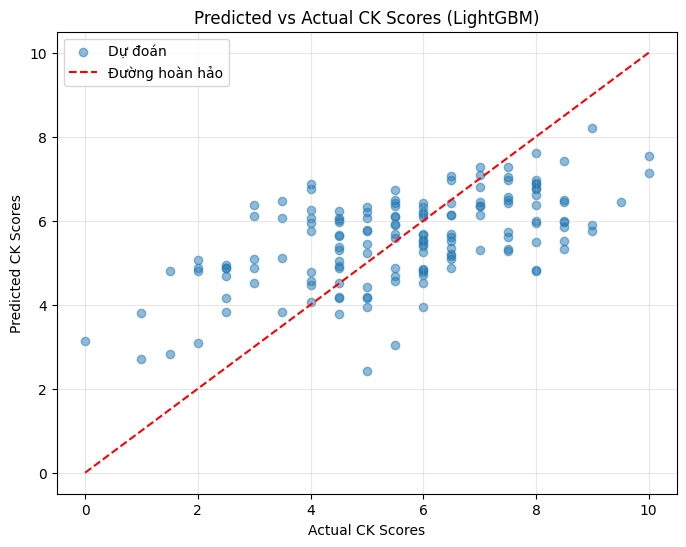

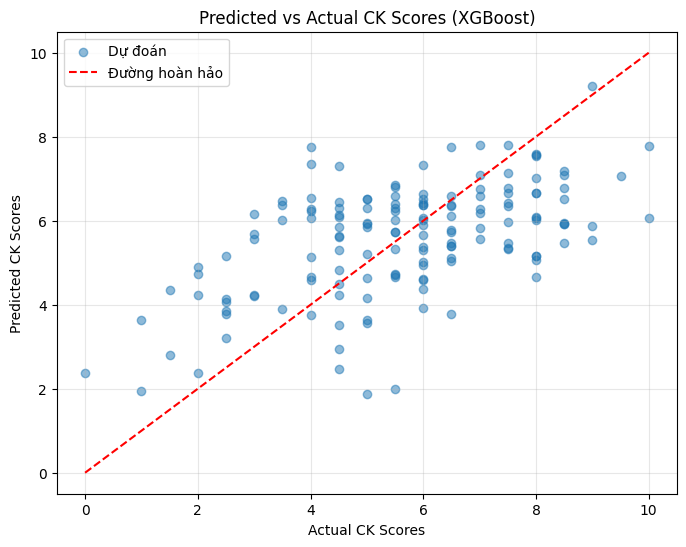

In [ ]:
    # Dự đoán trên tập kiểm tra với LightGBM
    y_pred_lgb = model_lgb.predict(X_val)

    # Tạo biểu đồ cho LightGBM
    plot_predictions(y_val, y_pred_lgb, model_name='LightGBM')

    # Dự đoán trên tập kiểm tra với XGBoost
    # Chuyển đổi X_val thành DMatrix
    dval = xgb.DMatrix(X_val)
    y_pred_xgb = model_xgb.predict(dval)

    # Tạo biểu đồ cho XGBoost
    plot_predictions(y_val, y_pred_xgb, model_name='XGBoost')